In [26]:
import pandas as pd
import numpy as np
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
import keras.utils.np_utils as kutils
import numpy.random as rnd
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from pandas import Series
from pandas import DataFrame
from pandas import concat
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X = X.values.tolist()
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        if dataset[i + look_back] > dataset[i + look_back - 1]:
            dataY.append([0,1])
        else:
            dataY.append([1,0])
    return np.array(dataX), np.array(dataY)

def timeseries_to_supervised(data, lag=1,withY  = False):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    if withY:
        columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def make_X_LSTM(data, withY = True, look_back = 1):
    X = data
    if withY == True:
        X= data[:, 0:-1]
    res = []
    for j in range(look_back-1,X.shape[0]):
        tmp = []
        for i in range(look_back-1,-1,-1):
            tmp.append(X[j-i,:])
        res.append(tmp)
        
    #X = X.reshape(X.shape[0], 1, X.shape[1])
    return np.array(res)
    

In [120]:
#read from csv 
from numpy import genfromtxt
import os
data = pd.read_csv('data_day1.csv')
data.columns

Index(['Unnamed: 0', 'USDRUB.Open', 'USDRUB.High', 'USDRUB.Low',
       'USDRUB.Close', 'USDRUB.Volume', 'ClCl.USDRUB.Open',
       'RSI.10.USDRUB.Open', 'RSI.20.USDRUB.Open', 'RSI.40.USDRUB.Open',
       'SMA.5.USDRUB.Open', 'SMA.10.USDRUB.Open', 'SMA.30.USDRUB.Open',
       'SMA.100.USDRUB.Open', 'MACD.nFast.12.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.12.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.2.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.2.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.5.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.5.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.12.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.12.nSlow.14.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.2.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.2.nSlow.14.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.5.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.5.nSlow.14.nSig.9.signal.USDRUB.Open',
       'BBands.n.20

In [4]:
data.head(5)

,Unnamed: 0,USDRUB.Open,USDRUB.High,USDRUB.Low,USDRUB.Close,USDRUB.Volume,ClCl.USDRUB.Open,RSI.10.USDRUB.Open,RSI.20.USDRUB.Open,SMA.5.USDRUB.Open,...,BBands.n.20.sd.2.up.USDRUB.Open,BBands.n.20.sd.2.pctB.USDRUB.Open,BBands.n.50.sd.2.dn.USDRUB.Open,BBands.n.50.sd.2.mavg.USDRUB.Open,BBands.n.50.sd.2.up.USDRUB.Open,BBands.n.50.sd.2.pctB.USDRUB.Open,BBands.n.80.sd.2.dn.USDRUB.Open,BBands.n.80.sd.2.mavg.USDRUB.Open,BBands.n.80.sd.2.up.USDRUB.Open,BBands.n.80.sd.2.pctB.USDRUB.Open
0,1999-05-20,24.700,24.700,24.700,24.700,0,-0.002020,46.948452,49.745158,25.0996,...,25.511010,0.509050,23.124503,24.862567,26.600631,0.453233,21.822025,24.144729,26.467433,0.619531
1,1999-05-21,24.650,24.650,24.650,24.650,0,-0.002024,46.010874,49.303043,24.8898,...,25.487106,0.487720,23.204641,24.888767,26.572892,0.429113,21.861551,24.167604,26.473657,0.604593
2,1999-05-24,24.600,24.600,24.600,24.600,0,-0.002028,45.012088,48.846069,24.6700,...,25.459931,0.467413,23.280795,24.912767,26.544738,0.404175,21.892425,24.186854,26.481284,0.590032
3,1999-05-25,24.634,24.634,24.634,24.634,0,0.001382,45.899408,49.183209,24.6668,...,25.463672,0.484263,23.361365,24.937447,26.513529,0.403734,21.924503,24.206654,26.488805,0.593628
4,1999-05-26,24.634,24.634,24.634,24.634,0,0.000000,45.899408,49.183209,24.6436,...,25.466954,0.480661,23.445596,24.962127,26.478657,0.391817,21.976931,24.232079,26.487227,0.589112


In [121]:

df = data.copy()
X = df[["USDRUB.Close",'RSI.20.USDRUB.Open','BBands.n.50.sd.2.pctB.USDRUB.Open',
      'SMA.10.USDRUB.Open','ClCl.USDRUB.Open']]
X = df[['USDRUB.Close','USDRUB.Open', 'USDRUB.High', 'USDRUB.Low',
       'USDRUB.Volume', 'ClCl.USDRUB.Open',
       'RSI.10.USDRUB.Open', 'RSI.20.USDRUB.Open', 'RSI.40.USDRUB.Open',
       'SMA.5.USDRUB.Open', 'SMA.10.USDRUB.Open', 'SMA.30.USDRUB.Open',
       'SMA.100.USDRUB.Open', 'MACD.nFast.12.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.12.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.2.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.2.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.5.nSlow.26.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.5.nSlow.26.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.12.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.12.nSlow.14.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.2.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.2.nSlow.14.nSig.9.signal.USDRUB.Open',
       'MACD.nFast.5.nSlow.14.nSig.9.macd.USDRUB.Open',
       'MACD.nFast.5.nSlow.14.nSig.9.signal.USDRUB.Open',
       'BBands.n.20.sd.2.dn.USDRUB.Open', 'BBands.n.20.sd.2.mavg.USDRUB.Open',
       'BBands.n.20.sd.2.up.USDRUB.Open', 'BBands.n.20.sd.2.pctB.USDRUB.Open',
       'BBands.n.50.sd.2.dn.USDRUB.Open', 'BBands.n.50.sd.2.mavg.USDRUB.Open',
       'BBands.n.50.sd.2.up.USDRUB.Open', 'BBands.n.50.sd.2.pctB.USDRUB.Open',
       'BBands.n.80.sd.2.dn.USDRUB.Open', 'BBands.n.80.sd.2.mavg.USDRUB.Open',
       'BBands.n.80.sd.2.up.USDRUB.Open', 'BBands.n.80.sd.2.pctB.USDRUB.Open',
       'stoch.nFastK.14.nFastD.1.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.14.nFastD.1.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.14.nFastD.1.nSlowD.3.slowD.USDRUB.Open',
       'stoch.nFastK.10.nFastD.1.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.10.nFastD.1.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.10.nFastD.1.nSlowD.3.slowD.USDRUB.Open',
       'stoch.nFastK.7.nFastD.1.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.7.nFastD.1.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.7.nFastD.1.nSlowD.3.slowD.USDRUB.Open',
       'stoch.nFastK.14.nFastD.3.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.14.nFastD.3.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.14.nFastD.3.nSlowD.3.slowD.USDRUB.Open',
       'stoch.nFastK.10.nFastD.3.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.10.nFastD.3.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.10.nFastD.3.nSlowD.3.slowD.USDRUB.Open',
       'stoch.nFastK.7.nFastD.3.nSlowD.3.fastK.USDRUB.Open',
       'stoch.nFastK.7.nFastD.3.nSlowD.3.fastD.USDRUB.Open',
       'stoch.nFastK.7.nFastD.3.nSlowD.3.slowD.USDRUB.Open',
       'SMI.n.13.nFast.2.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.13.nFast.2.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.10.nFast.2.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.10.nFast.2.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.7.nFast.2.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.7.nFast.2.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.13.nFast.4.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.13.nFast.4.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.10.nFast.4.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.10.nFast.4.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.7.nFast.4.nSlow.25.nSig.9.SMI.USDRUB.Open',
       'SMI.n.7.nFast.4.nSlow.25.nSig.9.signal.USDRUB.Open',
       'SMI.n.13.nFast.2.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.13.nFast.2.nSlow.25.nSig.4.signal.USDRUB.Open',
       'SMI.n.10.nFast.2.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.10.nFast.2.nSlow.25.nSig.4.signal.USDRUB.Open',
       'SMI.n.7.nFast.2.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.7.nFast.2.nSlow.25.nSig.4.signal.USDRUB.Open',
       'SMI.n.13.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.13.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open',
       'SMI.n.10.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.10.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open',
       'SMI.n.7.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open',
       'SMI.n.7.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open',
       'ZigZag.3.USDRUB.Open', 'ZigZag.5.USDRUB.Open', 'ZigZag.10.USDRUB.Open',
       'ZigZag.20.USDRUB.Open']]

In [122]:
X.head(5)

,USDRUB.Close,USDRUB.Open,USDRUB.High,USDRUB.Low,USDRUB.Volume,ClCl.USDRUB.Open,RSI.10.USDRUB.Open,RSI.20.USDRUB.Open,RSI.40.USDRUB.Open,SMA.5.USDRUB.Open,...,SMI.n.13.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open,SMI.n.13.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open,SMI.n.10.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open,SMI.n.10.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open,SMI.n.7.nFast.4.nSlow.25.nSig.4.SMI.USDRUB.Open,SMI.n.7.nFast.4.nSlow.25.nSig.4.signal.USDRUB.Open,ZigZag.3.USDRUB.Open,ZigZag.5.USDRUB.Open,ZigZag.10.USDRUB.Open,ZigZag.20.USDRUB.Open
0,24.445,24.494,24.494,24.445,0,-0.002652,44.123574,47.410102,50.612298,24.4806,...,-36.012539,-36.930992,-28.319462,-29.528078,-19.624278,-20.963279,25.054566,25.054566,24.501317,23.753317
1,24.464,24.464,24.464,24.464,0,0.000777,45.306581,47.759057,50.729166,24.5006,...,-35.418205,-36.325877,-27.724099,-28.806486,-19.155829,-20.240299,25.026547,25.026547,24.509926,23.762744
2,24.464,24.464,24.464,24.464,0,0.000000,45.306581,47.759057,50.729166,24.4736,...,-34.850001,-35.735527,-27.198877,-28.163443,-18.804624,-19.666029,24.998528,24.998528,24.518535,23.772172
3,24.434,24.464,24.464,24.434,0,-0.001226,43.510859,47.210994,50.530562,24.4634,...,-34.556633,-35.263969,-27.053656,-27.719528,-18.967840,-19.386753,24.970509,24.970509,24.527144,23.781599
4,24.344,24.434,24.434,24.344,0,-0.003683,38.433205,45.559961,49.929110,24.4302,...,-35.146372,-35.216930,-28.056912,-27.854481,-20.631140,-19.884508,24.942491,24.942491,24.535753,23.791027


In [123]:
# not to change look_back!!!
look_back = 1
res = DataFrame()
for i in range(X.shape[1]-1,-1,-1):
    raw_values = X[[i]].values
    raw_values = raw_values.reshape(raw_values.shape[0])
    diff_values = difference(raw_values, 1)
    if i == 0:
        supervised = timeseries_to_supervised(diff_values, look_back,withY = True)
    else:
        supervised = timeseries_to_supervised(diff_values, look_back,withY = False)
    res = pd.concat([res,DataFrame(supervised.values)],axis = 1)
supervised_values = res.values
# split data into train and test-sets
p = 0.7
train, test = supervised_values[0:int(len(supervised_values) * p)], supervised_values[int(len(supervised_values) * p):]
 

In [146]:
batch_size = 20
look_back = 1
scaler, trainX, testX = scale(train[:,:-1],
                              test[:,:-1])
trainX = make_X_LSTM(trainX, withY = False,look_back = look_back)
testX = make_X_LSTM(testX, withY = False,look_back = look_back)

trainX = trainX[0:(trainX.shape[0]//batch_size) * batch_size,:,:]
testX = testX[0:(testX.shape[0]//batch_size) * batch_size,:,:]

#train Y
trainY = train[(look_back - 1):,-1] > 0
trainY = trainY[0:(trainY.shape[0]//batch_size) * batch_size,]
#test Y
testY = test[(look_back - 1):,-1] > 0
testY = testY[0:(testY.shape[0]//batch_size) * batch_size,]

In [237]:


model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), 
               stateful=True,
               return_sequences=True))
model.add(ActivityRegularization(l1=0.0001, l2=0.0001))
model.add(Dropout(0.15))
model.add(LSTM(8))
model.add(Dropout(0.15))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy',
          optimizer='adam',
          class_mode="binary",
          metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (20, 1, 2)                688       
_________________________________________________________________
activity_regularization_26 ( (20, 1, 2)                0         
_________________________________________________________________
dropout_55 (Dropout)         (20, 1, 2)                0         
_________________________________________________________________
lstm_57 (LSTM)               (20, 8)                   352       
_________________________________________________________________
dropout_56 (Dropout)         (20, 8)                   0         
_________________________________________________________________
dense_55 (Dense)             (20, 8)                   72        
_________________________________________________________________
activation_55 (Activation)   (20, 8)                   0         
__________

In [238]:
best_acc = 0
lowest_loss = 10000000
train_acc = []
test_acc = []
train_loss = []
test_loss = []

In [239]:

nchar = 4
nb_epoch = 50
for i in range(nb_epoch):
    print("Block",i + 1,"/",nb_epoch)
    history = model.fit(trainX, 
                        trainY, 
                        nb_epoch=1,
                        batch_size=batch_size, 
                        verbose=0, 
                        shuffle=False, 
                        validation_data=(testX, testY)
         )
    print("Train acc:",'%.4f' % round(history.history['acc'][0], nchar) ,",    ",
         "Test acc:", '%.4f' % round(history.history['val_acc'][0], nchar))
    train_acc.append(history.history['acc'][0])
    train_loss.append(history.history['loss'][0])
    test_acc.append(history.history['val_acc'][0])
    test_loss.append(history.history['val_loss'][0])
    if history.history['val_loss'][0] < lowest_loss:
        model.save('best_model.h5')
        best_acc = history.history['val_acc'][0]
        lowest_loss = history.history['val_loss'][0]
        print("Model successfully saved ","val_acc = ",'%.4f' % round(best_acc, nchar))
    model.reset_states()
    


Block 1 / 50


/usr/local/lib/python3.5/dist-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train acc: 0.5644 ,     Test acc: 0.4817
Model successfully saved  val_acc =  0.4817
Block 2 / 50
Train acc: 0.5647 ,     Test acc: 0.4817
Block 3 / 50
Train acc: 0.5647 ,     Test acc: 0.4817
Block 4 / 50
Train acc: 0.5647 ,     Test acc: 0.4817
Block 5 / 50
Train acc: 0.5647 ,     Test acc: 0.4817
Model successfully saved  val_acc =  0.4817
Block 6 / 50
Train acc: 0.5649 ,     Test acc: 0.4835
Model successfully saved  val_acc =  0.4835
Block 7 / 50
Train acc: 0.5662 ,     Test acc: 0.4909
Model successfully saved  val_acc =  0.4909
Block 8 / 50
Train acc: 0.5686 ,     Test acc: 0.5195
Model successfully saved  val_acc =  0.5195
Block 9 / 50
Train acc: 0.5725 ,     Test acc: 0.5384
Model successfully saved  val_acc =  0.5384
Block 10 / 50
Train acc: 0.5783 ,     Test acc: 0.5506
Model successfully saved  val_acc =  0.5506
Block 11 / 50
Train acc: 0.5764 ,     Test acc: 0.5579
Block 12 / 50
Train acc: 0.5819 ,     Test acc: 0.5500
Block 13 / 50
Train acc: 0.5796 ,     Test acc: 0.5585

In [240]:
best_acc


0.55060975726057848

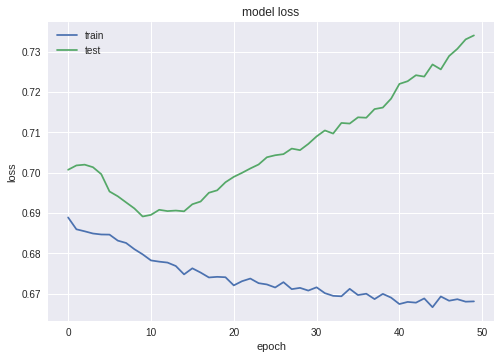

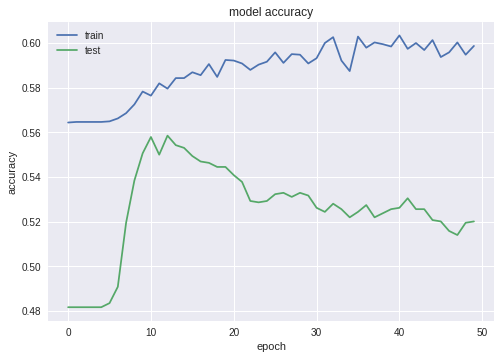

In [241]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()